In [1]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split, KFold
print(tf.__version__)

2.11.0


In [2]:
data_path = "TCIR-ALL_2017.h5"
data_info = pd.read_hdf(data_path, key="info", mode='r')
with h5py.File(data_path, 'r') as hf:
    data_matrix = hf['matrix'][:]

In [3]:
print("Min Intensity ",data_info.Vmax.min())
print("Max Intensity ",data_info.Vmax.max())
print("Mean Intensity ",round(data_info.Vmax.mean(),2))

Min Intensity  15.0
Min Intensity  155.0
Min Intensity  48.14


In [4]:
np.shape(data_matrix)

(4580, 201, 201, 4)

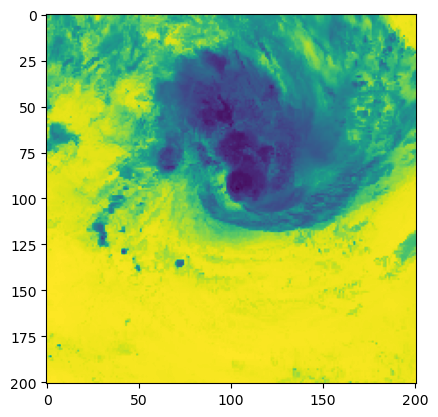

In [5]:
img = data_matrix[4000,:,:,0].copy()
fig, ax = plt.subplots()
pos = ax.imshow(img)

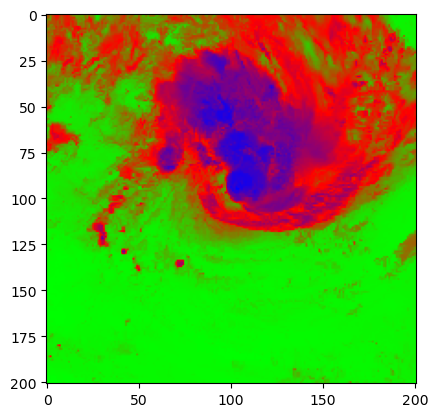

In [6]:
img = data_matrix[4000,:,:,0].copy()
fig, ax = plt.subplots()
pos = ax.imshow(img,plt.cm.brg)

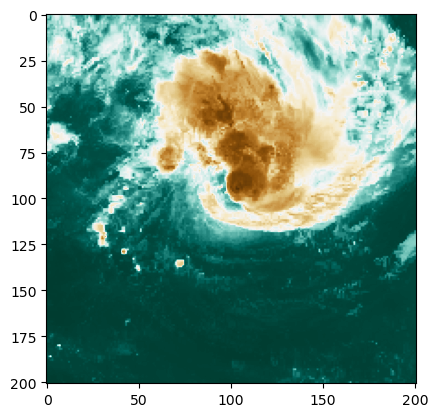

In [7]:
img = data_matrix[4000,:,:,0].copy()
fig, ax = plt.subplots()
pos = ax.imshow(img,plt.cm.BrBG)

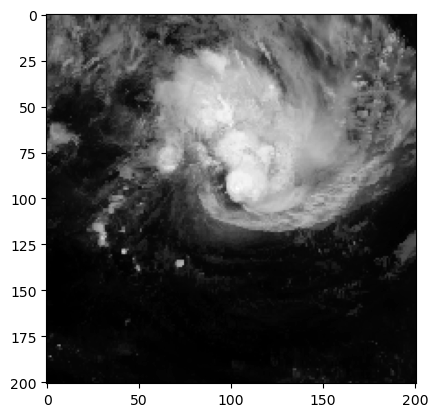

In [8]:
img = data_matrix[4000,:,:,0].copy()
fig, ax = plt.subplots()
pos = ax.imshow(img,plt.cm.binary)

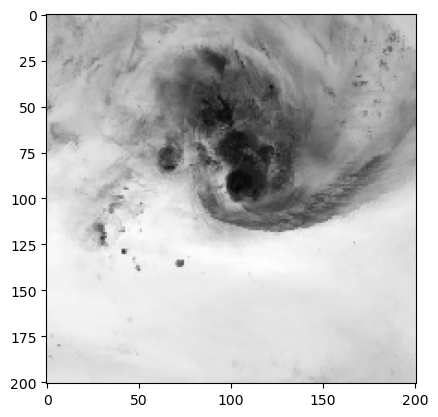

In [9]:
img = data_matrix[4000,:,:,1].copy()
fig, ax = plt.subplots()
pos = ax.imshow(img, plt.cm.gray)

In [10]:
data_info = data_info.assign(time=pd.to_datetime(data_info.time, format=r'%Y%m%d%H'))

In [11]:
## keep only IR and PMW
X_irpmw = data_matrix[:,:,:,0::3]
y = data_info['Vmax'].values[:,np.newaxis]

In [12]:
X_irpmw[np.isnan(X_irpmw)] = 0
X_irpmw[X_irpmw > 1000] = 0

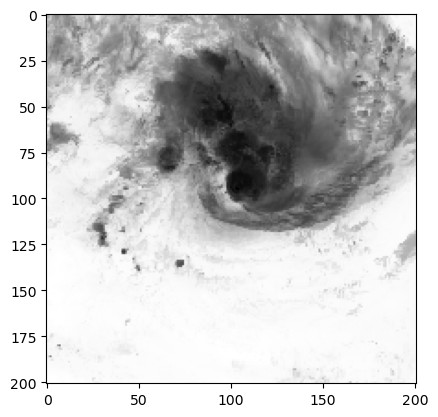

In [13]:
# X_std = tf.image.per_image_standardization(X_irpmw)
img = data_matrix[4000,:,:,0].copy()
fig, ax = plt.subplots()
pos = ax.imshow(img, plt.cm.gray)

In [14]:
class Preprocessing(keras.layers.Layer):
    def __init__(self):
        super(Preprocessing, self).__init__()
    def call(self, inputs, training=None):
        if training:
            inputs = tf.image.rot90(inputs, k=np.random.randint(4))
        return tf.image.central_crop(inputs, 0.5)

## Alexnet CNN

In [15]:

def train_val_model(train_x,train_y,val_x,val_y, n_epochs, batch_size):
    reg_param = 1e-5
    
    train_X = tf.convert_to_tensor(train_x)
    train_Y = tf.convert_to_tensor(train_y)
    
    val_X = tf.convert_to_tensor(val_x)
    val_Y = tf.convert_to_tensor(val_y)
    
    weights_initializer = keras.initializers.GlorotUniform()
    

    model = keras.models.Sequential([
        Preprocessing(),
        keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=4,padding='valid', activation='relu', input_shape=(224,224,3)),
        keras.layers.MaxPool2D(pool_size=(3, 3),strides=2),
        keras.layers.Conv2D(filters=256, kernel_size=(5,5), padding='same', activation='relu'),
        keras.layers.MaxPool2D(pool_size=(3, 3),strides=2),
        keras.layers.Conv2D(filters=384, kernel_size=(3,3), padding='same', activation='relu'),
        keras.layers.Conv2D(filters=384, kernel_size=(3,3), padding='same', activation='relu'),
        keras.layers.Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'),
        keras.layers.MaxPool2D(pool_size=(3, 3),strides=2),
        keras.layers.Flatten(),
        keras.layers.Dense(4096, activation='relu'),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(4096, activation='relu'),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(1, activation='relu'),
    ])
    
    #Compiling the model
    model.compile(optimizer=keras.optimizers.Adam(lr=5e-4, beta_1=0.99, beta_2=0.9999),
                  loss='mean_squared_error', 
                  metrics=['mean_squared_error'], 
                 )
 
    #Training the network
    history = model.fit(train_X,train_Y, 
         epochs=n_epochs,
         batch_size=batch_size, 
         verbose=1
        )
    
    val_score = model.evaluate(val_X, val_Y)
    print("Val Score: ",val_score)
    return history,val_score,model

In [16]:
model_history=[]
val_scores=[]
n_epochs=20
batch_size=256
train_x, val_x, train_y, val_y = train_test_split(X_irpmw, y, random_state = 101, test_size=0.1)
train_x, test_x, train_y, test_y = train_test_split(train_x, train_y, random_state = 101, test_size=0.1)
history,val_score,model = train_val_model(train_x,train_y,val_x,val_y, n_epochs, batch_size)
model_history.append(history)
val_scores.append(val_score)

Epoch 1/20
15/15 [==============================] - 93s 6s/step - loss: 2820257.2500 - mean_squared_error: 2820257.2500
Epoch 2/20
15/15 [==============================] - 89s 6s/step - loss: 3088.4087 - mean_squared_error: 3088.4087
Epoch 3/20
15/15 [==============================] - 97s 6s/step - loss: 3088.4087 - mean_squared_error: 3088.4087
Epoch 4/20
15/15 [==============================] - 106s 7s/step - loss: 3088.4087 - mean_squared_error: 3088.4087
Epoch 5/20
15/15 [==============================] - 105s 7s/step - loss: 3088.4087 - mean_squared_error: 3088.4087
Epoch 6/20
15/15 [==============================] - 108s 7s/step - loss: 3088.4087 - mean_squared_error: 3088.4087
Epoch 7/20
15/15 [==============================] - 110s 7s/step - loss: 3088.4087 - mean_squared_error: 3088.4087
Epoch 8/20
15/15 [==============================] - 108s 7s/step - loss: 3088.4087 - mean_squared_error: 3088.4087
Epoch 9/20
15/15 [==============================] - 104s 7s/step - loss: 3088

In [17]:
y_pred = model.predict(test_x)
print('Testing...')
score = model.evaluate(test_x,test_y,
                     batch_size=16, verbose=1)

print('Test accuracy:', score[1])

13/13 [==============================] - 3s 178ms/step
Testing...
26/26 [==============================] - 3s 88ms/step - loss: 2786.2808 - mean_squared_error: 2786.2808
Test accuracy: 2786.28076171875


In [18]:
abcd = []
for x in y_pred:
    abcd.append(int(x))

In [19]:
cate = []
for x in abcd:
    if x <=33:
        cate.append('Tropical Depression')
    elif x>33 and x<=63:
        cate.append('Tropical Storm')
    elif x>63 and x<=129:
        cate.append('Typhoon')
    elif x>129:
        cate.append('Super Typhoon')

In [20]:
cate_dataset = list(zip(abcd,cate))

In [21]:
df = pd.DataFrame(cate_dataset,columns=['Intensity','Category',])

In [22]:
df

,Intensity,Category
0,0,Tropical Depression
1,0,Tropical Depression
2,0,Tropical Depression
3,0,Tropical Depression
4,0,Tropical Depression
...,...,...
408,0,Tropical Depression
409,0,Tropical Depression
410,0,Tropical Depression
411,0,Tropical Depression


## Deep CNN

In [23]:

def train_val_model(train_x,train_y,val_x,val_y, n_epochs, batch_size):
    reg_param = 1e-5
    
    train_X = tf.convert_to_tensor(train_x)
    train_Y = tf.convert_to_tensor(train_y)
    
    val_X = tf.convert_to_tensor(val_x)
    val_Y = tf.convert_to_tensor(val_y)
    
    weights_initializer = keras.initializers.GlorotUniform()
    

    model = keras.models.Sequential([
        Preprocessing(),
        keras.layers.Conv2D(filters=16, kernel_size=4, strides=2, padding='valid', activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        keras.layers.Conv2D(filters=32, kernel_size=3, strides=2, padding='valid', activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        keras.layers.Conv2D(filters=64, kernel_size=3, strides=2, padding='valid', activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        keras.layers.Conv2D(filters=128, kernel_size=3, strides=2, padding='valid', activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        keras.layers.Flatten(),
        keras.layers.Dense(256, activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        keras.layers.Dense(128, activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
        keras.layers.Dense(1, activation='relu', kernel_initializer = weights_initializer, kernel_regularizer=keras.regularizers.l2(reg_param)),
    ])
    #Compiling the model
    model.compile(optimizer=keras.optimizers.Adam(lr=5e-4, beta_1=0.99, beta_2=0.9999),
                  loss='mean_squared_error', 
                  metrics=['mean_squared_error'], 
                 )

    #Training the network
    history = model.fit(train_X,train_Y, 
         epochs=n_epochs,
         batch_size=batch_size, 
         verbose=1
        )
    
    val_score = model.evaluate(val_X, val_Y)
    print("Val Score: ",val_score)
    return history,val_score,model


In [24]:
model_history=[]
val_scores=[]
n_epochs=10
batch_size=64
train_x, val_x, train_y, val_y = train_test_split(X_irpmw, y, random_state = 101, test_size=0.1)
train_x, test_x, train_y, test_y = train_test_split(train_x, train_y, random_state = 101, test_size=0.1)
history,val_score,model = train_val_model(train_x,train_y,val_x,val_y, n_epochs, batch_size)
model_history.append(history)
val_scores.append(val_score)

Epoch 1/10


C:\Users\Lanchavi\anaconda3\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


58/58 [==============================] - 13s 168ms/step - loss: 1717.6509 - mean_squared_error: 1717.6438
Epoch 2/10
58/58 [==============================] - 10s 168ms/step - loss: 792.3565 - mean_squared_error: 792.3510
Epoch 3/10
58/58 [==============================] - 10s 169ms/step - loss: 699.1877 - mean_squared_error: 699.1821
Epoch 4/10
58/58 [==============================] - 10s 171ms/step - loss: 548.5716 - mean_squared_error: 548.5654
Epoch 5/10
58/58 [==============================] - 10s 173ms/step - loss: 426.1301 - mean_squared_error: 426.1238
Epoch 6/10
58/58 [==============================] - 10s 172ms/step - loss: 395.9386 - mean_squared_error: 395.9320
Epoch 7/10
58/58 [==============================] - 10s 170ms/step - loss: 332.8974 - mean_squared_error: 332.8907
Epoch 8/10
58/58 [==============================] - 10s 176ms/step - loss: 313.9453 - mean_squared_error: 313.9384
Epoch 9/10
58/58 [==============================] - 10s 177ms/step - loss: 298.0243 - mea

In [25]:
y_pred = model.predict(test_x)
print('Testing...')
score = model.evaluate(test_x,test_y,
                     batch_size=16, verbose=1)
print('Test accuracy:', score[1])

13/13 [==============================] - 1s 38ms/step
Testing...
26/26 [==============================] - 1s 30ms/step - loss: 372.6271 - mean_squared_error: 372.6201
Test accuracy: 372.62005615234375


In [26]:
abcd = []
for x in y_pred:
    abcd.append(int(x))

In [27]:
cate = []
for x in abcd:
    if x <=33:
        cate.append('Tropical Depression')
    elif x>33 and x<=63:
        cate.append('Tropical Storm')
    elif x>63 and x<=129:
        cate.append('Typhoon')
    elif x>129:
        cate.append('Super Typhoon')

In [28]:
cate_dataset = list(zip(abcd,cate))

In [29]:
df = pd.DataFrame(cate_dataset,columns=['Intensity','Category',])

In [30]:
df

,Intensity,Category
0,46,Tropical Storm
1,35,Tropical Storm
2,27,Tropical Depression
3,49,Tropical Storm
4,32,Tropical Depression
...,...,...
408,27,Tropical Depression
409,31,Tropical Depression
410,30,Tropical Depression
411,29,Tropical Depression


## Kfold 

In [31]:
n_epochs=5
batch_size=32
model_history = []  #save the model history in a list after fitting so that we can plot later
val_scores=[]
kf = KFold(n_splits=3)

i=0
for train_index, test_index in kf.split(X_irpmw):
    print("Training on Fold: ",i+1)
    i+=1
    train_x, val_x = X_irpmw[train_index], X_irpmw[test_index]
    train_y, val_y = y[train_index], y[test_index]
    history,val_score,model = train_val_model(train_x,train_y,val_x,val_y, n_epochs, batch_size)
    model_history.append(history)
    val_scores.append(val_score)
    print("======="*12, end="\n\n\n")

Training on Fold:  1


Epoch 1/5


C:\Users\Lanchavi\anaconda3\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


96/96 [==============================] - 16s 114ms/step - loss: 3626.4509 - mean_squared_error: 3626.4500
Epoch 2/5
96/96 [==============================] - 11s 114ms/step - loss: 2556.8965 - mean_squared_error: 2556.8933
Epoch 3/5
96/96 [==============================] - 10s 106ms/step - loss: 2556.8965 - mean_squared_error: 2556.8933
Epoch 4/5
96/96 [==============================] - 11s 115ms/step - loss: 2556.8967 - mean_squared_error: 2556.8933
Epoch 5/5
48/48 [==============================] - 3s 47ms/step - loss: 3910.4319 - mean_squared_error: 3910.4282
Val Score:  [3910.431884765625, 3910.42822265625]


Training on Fold:  2


Epoch 1/5
96/96 [==============================] - 24s 134ms/step - loss: 1464.9386 - mean_squared_error: 1464.9324
Epoch 2/5
96/96 [==============================] - 12s 125ms/step - loss: 891.7704 - mean_squared_error: 891.7651
Epoch 3/5
96/96 [==============================] - 12s 127ms/step - loss: 927.4048 - mean_squared_error: 927.3986
Epoch 4/5
96/96 [==============================] - 12s 122ms/step - loss: 825.9641 - mean_squared_error: 825.9578
Epoch 5/5
48/48 [==============================] - 3s 41ms/step - loss: 492.1506 - mean_squared_error: 492.1440
Val Score:  [492.15057373046875, 492.14404296875]


Training on Fold:  3


Epoch 1/5
96/96 [==============================] - 33s 207ms/step - loss: 1168.3140 - mean_squared_error: 1168.3077
Epoch 2/5
96/96 [==============================] - 18s 190ms/step - loss: 776.8970 - mean_squared_error: 776.8912
Epoch 3/5
96/96 [==============================] - 17s 181ms/step - loss: 465.3852 - mean_squared_error: 465.3786
Epoch 4/5
96/96 [==============================] - 15s 158ms/step - loss: 352.5368 - mean_squared_error: 352.5297
Epoch 5/5
48/48 [==============================] - 12s 188ms/step - loss: 445.5783 - mean_squared_error: 445.5709
Val Score:  [445.5782775878906, 445.5709228515625]




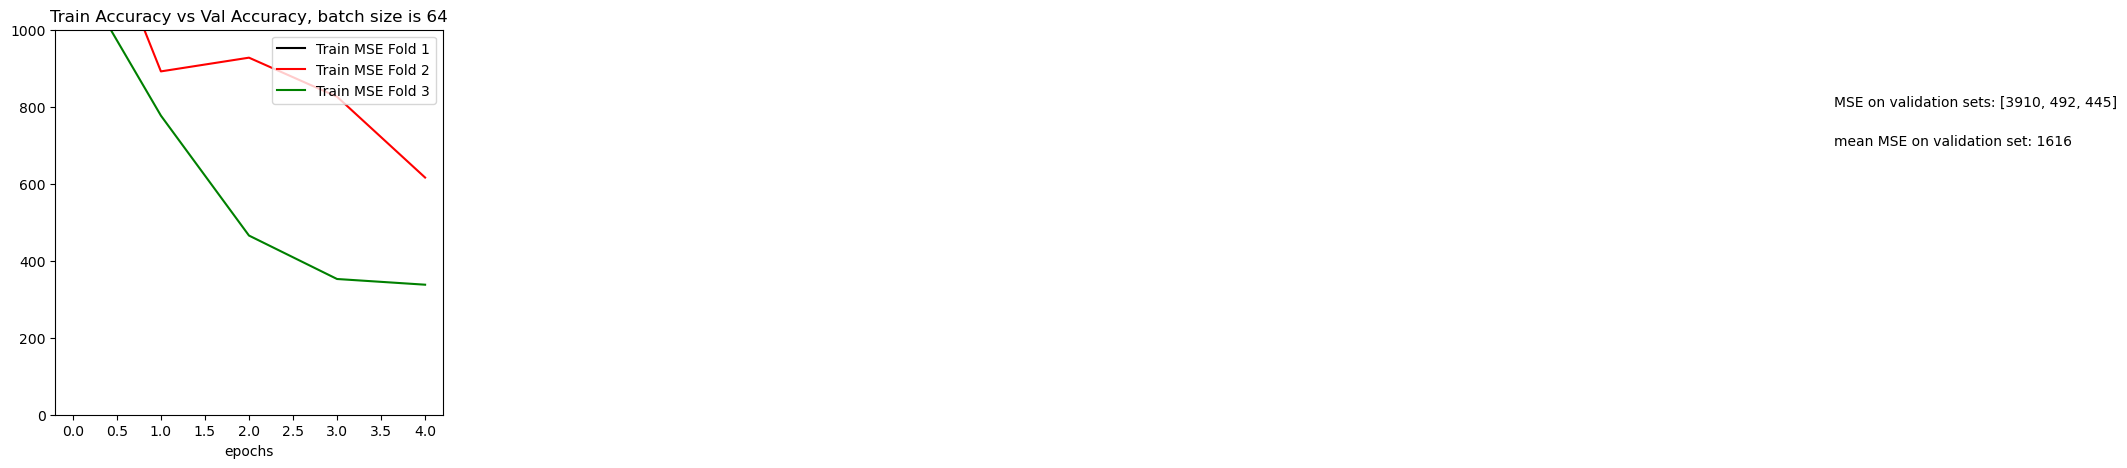

In [32]:
plt.figure(figsize=(5,5))
plt.title('Train Accuracy vs Val Accuracy, batch size is 64')
colors=['black','red','green']
for i in range(3):
    plt.plot(model_history[i].history['mean_squared_error'], label='Train MSE Fold '+str(i+1), color=colors[i])
#     plt.plot(model_history[i].history['val_mean_squared_error'], label='Val MSE Fold '+str(i+1), color=colors[i], linestyle = "dashdot")

plt.legend(loc='upper right')
plt.xlabel('epochs')
plt.ylim(0,1000)
plt.text(20,800,"MSE on validation sets: "+str([int(v) for v,v2 in val_scores]))
plt.text(20,700,"mean MSE on validation set: "+str(int(np.mean(val_scores,axis=0)[0])))
plt.show()